In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

from src.utils.helper import *
import pickle

with open('/Users/utkarsh/Documents/neural-toc/naacl_work/aviral_transformer_formal_language/models/shuffle2/vocab.p', 'rb') as f:
    vocab = pickle.load(f)
    
with open('/Users/utkarsh/Documents/neural-toc/naacl_work/aviral_transformer_formal_language/models/shuffle2/config.p', 'rb') as f:
    config = pickle.load(f)

In [3]:
from src.dataloader import *

data_path = '/Users/utkarsh/Documents/neural-toc/naacl_work/aviral_transformer_formal_language/data/Shuffle-2/train_corpus.pk'
with open(data_path, 'rb') as f:
    train_corpus = pickle.load(f)
    
train_loader = Sampler(train_corpus, vocab, 8)

src, _, wd_lens = train_loader.get_batch(0)
src.shape, wd_lens

['[([([()])][])]', '[(([[()]]))]', '(())', '[(())]', '([])', '[([((()))])]', '((((([((()))[]]))))[])', '()[[([])]]']


(torch.Size([22, 8]), tensor([14, 12,  4,  6,  4, 12, 22, 10]))

In [4]:
def pad_seq(seq, max_length, voc):
    seq += [voc.get_id('T') for i in range(max_length - len(seq))]
    return seq

def sent_to_idx(voc, sent, max_length=-1):
    idx_vec = []
    for w in sent:
        idx = voc.get_id(w)
        idx_vec.append(idx)

    idx_vec.append(voc.get_id('T'))
    idx_vec = pad_seq(idx_vec, max_length+1, voc)
    return idx_vec

def sents_to_idx(voc, sents):
    max_length = max([len(s) for s in sents])
    all_indexes = []
    for sent in sents:
        all_indexes.append(sent_to_idx(voc, sent, max_length))

    all_indexes = torch.tensor(all_indexes, dtype= torch.long)
    return all_indexes

raw = train_corpus.source
data_ids = sents_to_idx(vocab, raw)
data = data_ids[:, :-1]
data.shape

torch.Size([10000, 50])

In [5]:
OPEN_C = vocab.get_id('(')
CLOSE_C = vocab.get_id(')')
OPEN_S = vocab.get_id('[')
CLOSE_S = vocab.get_id(']')

print(OPEN_C, CLOSE_C, OPEN_S, CLOSE_S)

def simulate_stack(tokenised_paren):
    stack1 = []
    stack2 = []
    stack1_depths = []
    stack2_depths = []
    for token in tokenised_paren:
        token = token.item()
        if token == OPEN_C:
            stack1.append(token)
        elif token == OPEN_S:
            stack2.append(token)
        elif token == CLOSE_C:
            if not stack1:
                raise ValueError("Unmatched curved closing bracket")
            stack1.pop()
        elif token == CLOSE_S:
            if not stack2:
                raise ValueError("Unmatched square closing bracket")
            stack2.pop()
        stack1_depths.append(len(stack1))
        stack2_depths.append(len(stack2))
    if stack1 or stack2:
        raise ValueError("Unmatched opening brackets remain in stack")
    return stack1_depths, stack2_depths


def create_dataset(model, paren_tokens, device="cpu"):
    X = []
    Y = []

    model.eval()

    with torch.no_grad():
        for tokenised_paren in paren_tokens:
            output, internal = model.model(tokenised_paren.to(device).unsqueeze(0).T, get_encoder_reps=True)
            internal = internal.transpose(0, 1).squeeze(0)
            stack1_depths, stack2_depths = simulate_stack(tokenised_paren)
            for i, states in enumerate(internal):
                X.append(states.cpu().numpy())
                Y.append(stack1_depths[i])

    X_tensor = torch.tensor(X)
    Y_tensor = torch.tensor(Y)
    
    return X_tensor, Y_tensor

3 1 2 4


In [6]:
import src
import torch
from src.model import LanguageModel
from src.components.transformers import TransformerModel

import torch

chkpt_path = '/Users/utkarsh/Documents/neural-toc/naacl_work/aviral_transformer_formal_language/models/shuffle2/model_20.pt'
model = LanguageModel(config, vocab, 'cpu', None)
model.load_state_dict(torch.load(chkpt_path, map_location='cpu')['model_state_dict'])

<All keys matched successfully>

In [7]:
class ProbingClassifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(ProbingClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        # out = self.dropout(out)
        # out = self.fc2(out)
        # out = self.relu(out)
        # out = self.dropout(out)
        # out = self.fc3(out)
        # out = self.relu(out)
        # out = self.dropout(out)
        out = self.fc4(out)
        return out

def create_dataset(model, paren_tokens, device="cpu"):
    X = []
    Y = []
    
    model.eval()
    
    with torch.no_grad():
        for tokenised_paren in paren_tokens:
            tokens = tokenised_paren.to(device).unsqueeze(0).T
            output, internal = model.model(tokens, get_encoder_reps=True)
            
            internal = internal.transpose(0, 1).squeeze(0)
            stack1_depths, stack2_depth = simulate_stack(tokenised_paren)
            
            for i, states in enumerate(internal):
                X.append(states.cpu().numpy())
                Y.append(stack1_depths[i])
    
    # Convert to numpy for normalization
    X = np.array(X)
    
    # Normalize features
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    
    X_tensor = torch.tensor(X_normalized, dtype=torch.float32)
    Y_tensor = torch.tensor(Y, dtype=torch.long)
    
    return X_tensor, Y_tensor

def plot_accuracies(train_acc_orig, val_acc_orig, train_acc_random, val_acc_random):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_acc_orig) + 1)
    
    # Plot original task accuracies
    plt.plot(epochs, train_acc_orig, 'b-', label='Original Task - Train')
    plt.plot(epochs, val_acc_orig, 'b--', label='Original Task - Validation')
    
    # Plot random control task accuracies
    plt.plot(epochs, train_acc_random, 'r-', label='Random Control - Train')
    plt.plot(epochs, val_acc_random, 'r--', label='Random Control - Validation')
    
    plt.title('Probing Accuracy: Original vs Random Control')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Add chance level line
    num_classes = max(Y.max().item(), Y_random.max().item()) + 1
    chance_level = 1.0 / num_classes
    plt.axhline(y=chance_level, color='g', linestyle='--', label=f'Chance Level ({chance_level:.3f})')
    
    plt.tight_layout()
    plt.show()

def train_probe(X, Y, model_name="original", num_epochs=10, batch_size=32, learning_rate=0.001):
    input_size = X.shape[1]
    num_classes = Y.max().item() + 1
    print(f"Input Size: {input_size}, Num Classes: {num_classes}")
    
    dataset = TensorDataset(X, Y)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    probing_model = ProbingClassifier(input_size, num_classes).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(probing_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        probing_model.train()
        train_correct = 0
        train_total = 0
        train_loss = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = probing_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == targets).sum().item()
            train_total += targets.size(0)
        
        # Validation phase
        probing_model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = probing_model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == targets).sum().item()
                val_total += targets.size(0)
        
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        scheduler.step(avg_val_loss)
        
        print(f"{model_name} - Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print("-------------------")
    
    return train_accuracies, val_accuracies

Input Size: 32, Num Classes: 15
Original - Epoch [1/10]
Train Loss: 0.5506, Train Accuracy: 0.7701
Val Loss: 0.5154, Val Accuracy: 0.7961
-------------------
Original - Epoch [2/10]
Train Loss: 0.4972, Train Accuracy: 0.7966
Val Loss: 0.4889, Val Accuracy: 0.7935
-------------------
Original - Epoch [3/10]
Train Loss: 0.4774, Train Accuracy: 0.8046
Val Loss: 0.4730, Val Accuracy: 0.8026
-------------------
Original - Epoch [4/10]
Train Loss: 0.4659, Train Accuracy: 0.8104
Val Loss: 0.4651, Val Accuracy: 0.8085
-------------------
Original - Epoch [5/10]
Train Loss: 0.4568, Train Accuracy: 0.8164
Val Loss: 0.4520, Val Accuracy: 0.8220
-------------------
Original - Epoch [6/10]
Train Loss: 0.4491, Train Accuracy: 0.8217
Val Loss: 0.4425, Val Accuracy: 0.8248
-------------------
Original - Epoch [7/10]
Train Loss: 0.4426, Train Accuracy: 0.8250
Val Loss: 0.4392, Val Accuracy: 0.8276
-------------------
Original - Epoch [8/10]
Train Loss: 0.4375, Train Accuracy: 0.8273
Val Loss: 0.4446, V

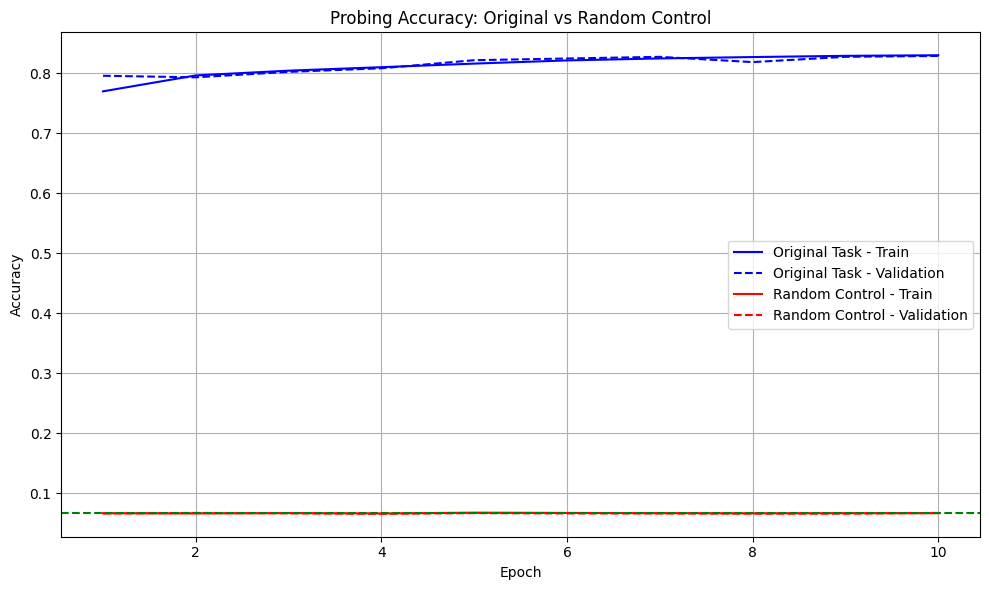

In [8]:
X, Y = create_dataset(model, data, "cpu")

# Create a control dataset with randomized labels
Y_random = torch.randint_like(Y, 0, Y.max().item() + 1)

# Train both the original and control probes
original_train_acc, original_val_acc = train_probe(X, Y, "Original")
random_train_acc, random_val_acc = train_probe(X, Y_random, "Control (Random)")

# Plot the results
plot_accuracies(original_train_acc, original_val_acc, random_train_acc, random_val_acc)

In [9]:
class ProbingClassifierAblation(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128, n_layers=1):
        super(ProbingClassifierAblation, self).__init__()
        self.n_layers = n_layers
        self.linear = nn.Linear(input_size, output_size)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.fc5 = nn.Linear(hidden_size, 256)
        self.fc6 = nn.Linear(256, output_size)
        self.fc7 = nn.Linear(256, hidden_size)
        self.fc8 = nn.Linear(256, 256)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        if self.n_layers == 0:
            out = self.linear(x)
        elif self.n_layers == 1:
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc4(out)
        elif self.n_layers == 2:
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            out = self.relu(out)
            out = self.fc4(out)
        elif self.n_layers == 3:
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            out = self.relu(out)
            out = self.fc3(out)
            out = self.relu(out)
            out = self.fc4(out)
        elif self.n_layers == 4:
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            out = self.relu(out)
            out = self.fc5(out)
            out = self.relu(out)
            out = self.fc8(out)
            out = self.relu(out)
            out = self.fc7(out)
            out = self.relu(out)
            out = self.fc4(out)
        return out

In [10]:
def train_probe_ablation(X, Y, model_name="original", num_epochs=10, batch_size=32, learning_rate=0.001, n_layers = 1):
    input_size = X.shape[1]
    num_classes = Y.max().item() + 1
    print(f"Input Size: {input_size}, Num Classes: {num_classes}")
    
    dataset = TensorDataset(X, Y)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    probing_model = ProbingClassifierAblation(input_size, num_classes, n_layers=n_layers).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(probing_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        probing_model.train()
        train_correct = 0
        train_total = 0
        train_loss = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = probing_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == targets).sum().item()
            train_total += targets.size(0)
        
        # Validation phase
        probing_model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = probing_model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == targets).sum().item()
                val_total += targets.size(0)
        
        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        scheduler.step(avg_val_loss)
        
        print(f"{model_name} - Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print("-------------------")
    
    return train_accuracies, val_accuracies

In [11]:
traintaskm0, valtaskm0 = train_probe_ablation(X, Y, "Original", n_layers=0)
reainrandomm0, valrandomm0 = train_probe_ablation(X, Y_random, "Control (Random)", n_layers=0)
tm0 = max(traintaskm0)
vm0 = max(valtaskm0)
rm0 = max(reainrandomm0)
rv0 = max(valrandomm0)

Input Size: 32, Num Classes: 15
Original - Epoch [1/10]
Train Loss: 0.6894, Train Accuracy: 0.7342
Val Loss: 0.5997, Val Accuracy: 0.7488
-------------------
Original - Epoch [2/10]
Train Loss: 0.5943, Train Accuracy: 0.7497
Val Loss: 0.5915, Val Accuracy: 0.7472
-------------------
Original - Epoch [3/10]
Train Loss: 0.5908, Train Accuracy: 0.7498
Val Loss: 0.5893, Val Accuracy: 0.7534
-------------------
Original - Epoch [4/10]
Train Loss: 0.5892, Train Accuracy: 0.7510
Val Loss: 0.5890, Val Accuracy: 0.7519
-------------------
Original - Epoch [5/10]
Train Loss: 0.5880, Train Accuracy: 0.7508
Val Loss: 0.5864, Val Accuracy: 0.7477
-------------------
Original - Epoch [6/10]
Train Loss: 0.5872, Train Accuracy: 0.7513
Val Loss: 0.5865, Val Accuracy: 0.7517
-------------------
Original - Epoch [7/10]
Train Loss: 0.5866, Train Accuracy: 0.7515
Val Loss: 0.5852, Val Accuracy: 0.7522
-------------------
Original - Epoch [8/10]
Train Loss: 0.5861, Train Accuracy: 0.7516
Val Loss: 0.5843, V

In [12]:
traintaskm1, valtaskm1 = train_probe_ablation(X, Y, "Original", n_layers=1)
trainrandomm1, valrandomm1 = train_probe_ablation(X, Y_random, "Control (Random)", n_layers=1)
tm1 = max(traintaskm1)
vm1 = max(valtaskm1)
rm1 = max(trainrandomm1)
rv1 = max(valrandomm1)

Input Size: 32, Num Classes: 15
Original - Epoch [1/10]
Train Loss: 0.5472, Train Accuracy: 0.7720
Val Loss: 0.5126, Val Accuracy: 0.8005
-------------------
Original - Epoch [2/10]
Train Loss: 0.5009, Train Accuracy: 0.7963
Val Loss: 0.4876, Val Accuracy: 0.7936
-------------------
Original - Epoch [3/10]
Train Loss: 0.4800, Train Accuracy: 0.8045
Val Loss: 0.4708, Val Accuracy: 0.8136
-------------------
Original - Epoch [4/10]
Train Loss: 0.4677, Train Accuracy: 0.8105
Val Loss: 0.4629, Val Accuracy: 0.8114
-------------------
Original - Epoch [5/10]
Train Loss: 0.4585, Train Accuracy: 0.8160
Val Loss: 0.4488, Val Accuracy: 0.8251
-------------------
Original - Epoch [6/10]
Train Loss: 0.4511, Train Accuracy: 0.8213
Val Loss: 0.4474, Val Accuracy: 0.8246
-------------------
Original - Epoch [7/10]
Train Loss: 0.4451, Train Accuracy: 0.8246
Val Loss: 0.4472, Val Accuracy: 0.8260
-------------------
Original - Epoch [8/10]
Train Loss: 0.4408, Train Accuracy: 0.8262
Val Loss: 0.4348, V

In [13]:
traintaskm2, valtaskm2 = train_probe_ablation(X, Y, "Original", n_layers=2)
trainrandomm2, valrandomm2 = train_probe_ablation(X, Y_random, "Control (Random)", n_layers=2)
tm2 = max(traintaskm2)
vm2 = max(valtaskm2)
rm2 = max(trainrandomm2)
rv2 = max(valrandomm2)

traintaskm3, valtaskm3 = train_probe_ablation(X, Y, "Original", n_layers=3)
trainrandomm3, valrandomm3 = train_probe_ablation(X, Y_random, "Control (Random)", n_layers=3)
tm3 = max(traintaskm3)
vm3 = max(valtaskm3)
rm3 = max(trainrandomm3)
rv3 = max(valrandomm3)

Input Size: 32, Num Classes: 15
Original - Epoch [1/10]
Train Loss: 0.4982, Train Accuracy: 0.7962
Val Loss: 0.4486, Val Accuracy: 0.8265
-------------------
Original - Epoch [2/10]
Train Loss: 0.4252, Train Accuracy: 0.8311
Val Loss: 0.4079, Val Accuracy: 0.8383
-------------------
Original - Epoch [3/10]
Train Loss: 0.3952, Train Accuracy: 0.8452
Val Loss: 0.3974, Val Accuracy: 0.8480
-------------------
Original - Epoch [4/10]
Train Loss: 0.3739, Train Accuracy: 0.8532
Val Loss: 0.3643, Val Accuracy: 0.8590
-------------------
Original - Epoch [5/10]
Train Loss: 0.3617, Train Accuracy: 0.8578
Val Loss: 0.3549, Val Accuracy: 0.8602
-------------------
Original - Epoch [6/10]
Train Loss: 0.3534, Train Accuracy: 0.8606
Val Loss: 0.3519, Val Accuracy: 0.8563
-------------------
Original - Epoch [7/10]
Train Loss: 0.3467, Train Accuracy: 0.8629
Val Loss: 0.3361, Val Accuracy: 0.8641
-------------------
Original - Epoch [8/10]
Train Loss: 0.3429, Train Accuracy: 0.8644
Val Loss: 0.3339, V

In [14]:
traintaskm4, valtaskm4 = train_probe_ablation(X, Y, "Original", n_layers=4)
trainrandomm4, valrandomm4 = train_probe_ablation(X, Y_random, "Control (Random)", n_layers=4)
tm4 = max(traintaskm4)
vm4 = max(valtaskm4)
rm4 = max(trainrandomm4)
rv4 = max(valrandomm4)

Input Size: 32, Num Classes: 15
Original - Epoch [1/10]
Train Loss: 0.4638, Train Accuracy: 0.8100
Val Loss: 0.3943, Val Accuracy: 0.8451
-------------------
Original - Epoch [2/10]
Train Loss: 0.3666, Train Accuracy: 0.8517
Val Loss: 0.3485, Val Accuracy: 0.8557
-------------------
Original - Epoch [3/10]
Train Loss: 0.3479, Train Accuracy: 0.8588
Val Loss: 0.3648, Val Accuracy: 0.8538
-------------------
Original - Epoch [4/10]
Train Loss: 0.3450, Train Accuracy: 0.8594
Val Loss: 0.3386, Val Accuracy: 0.8608
-------------------
Original - Epoch [5/10]
Train Loss: 0.3341, Train Accuracy: 0.8657
Val Loss: 0.3212, Val Accuracy: 0.8683
-------------------
Original - Epoch [6/10]
Train Loss: 0.3277, Train Accuracy: 0.8673
Val Loss: 0.3255, Val Accuracy: 0.8641
-------------------
Original - Epoch [7/10]
Train Loss: 0.3191, Train Accuracy: 0.8713
Val Loss: 0.3104, Val Accuracy: 0.8733
-------------------
Original - Epoch [8/10]
Train Loss: 0.3118, Train Accuracy: 0.8745
Val Loss: 0.3050, V

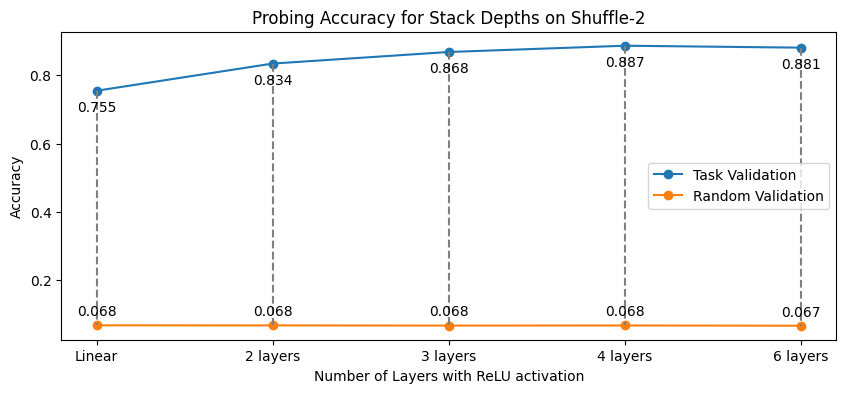

In [15]:
import matplotlib.pyplot as plt

# Define the lists
task_train = [tm0, tm1, tm2, tm3, tm4]
task_val = [vm0, vm1, vm2, vm3, vm4]
random_train = [rm0, rm1, rm2, rm3, rm4]
random_val = [rv0, rv1, rv2, rv3, rv4]

plt.figure(figsize=(10, 4))
# plt.plot(task_train, label='Task Train', marker='o')
plt.plot(task_val, label='Task Validation', marker='o')
# plt.plot(random_train, label='Random Train', marker='o')
plt.plot(random_val, label='Random Validation', marker='o')

# Add vertical lines between corresponding points of task_val and random_val
for i, (tv, rv) in enumerate(zip(task_val, random_val)):
    plt.vlines(x=i, ymin=tv, ymax=rv, colors='gray', linestyles='dashed')

for i, (tv, rv) in enumerate(zip(task_val, random_val)):
    plt.annotate(f'{tv:.3f}', (i, tv), textcoords="offset points", xytext=(0,-15), ha='center')
    plt.annotate(f'{rv:.3f}', (i, rv), textcoords="offset points", xytext=(0,7), ha='center')

# Add labels and title
plt.xlabel('Number of Layers with ReLU activation')
plt.ylabel('Accuracy')
plt.title('Probing Accuracy for Stack Depths on Shuffle-2')

# Add a legend
plt.legend()

# Set x-axis labels
plt.xticks([0, 1, 2, 3, 4], ['Linear', '2 layers', '3 layers', '4 layers', '6 layers'])
plt.savefig('shuffle2.png', dpi=300)
# Display the plot
plt.show()